# Neural Network for Spanish Tweets

## Upgrade gensim Package

In [ ]:
!pip install gensim --upgrade

     |████████████████████████████████| 24.2MB 130kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Libraries

In [ ]:
# Google Libraries
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Model Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, GRU, Dropout
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from gensim.models.keyedvectors import KeyedVectors
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

## Import Data

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# File Extraction
myfile = drive.CreateFile({'id': '1eOTGLFbP2nhf9YBNC34vQre5pQ4pl1jY'})
myfile.GetContentFile('Base_Tweets.csv')

In [ ]:
# Reading file
df = pd.read_csv('Base_Tweets.csv', encoding = 'latin')
df.head()

,content,polarity
0,QuÃ© gusto escuchar a una mujer como Maria Bla...,P
1,Es mÃ¡s fÃ¡cil levantarse por la maÃ±ana para ...,P
2,La presidenta aavv de amigos del canÃ³dromo de...,N
3,"Asi es, eso es lo q importa RT @el_cuartel: @m...",P
4,El @PSOE pone pegas ahora a encorsetar el gast...,N


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42367 entries, 0 to 42366
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   42367 non-null  object
 1   polarity  42367 non-null  object
dtypes: object(2)
memory usage: 662.1+ KB


In [ ]:
df.polarity.value_counts()

P    24426
N    17941
Name: polarity, dtype: int64

## Preprocessing

In [ ]:
# Label Vector
sent_dic = dict(zip(df.polarity.unique(), range(len(df.polarity.unique()))))
df["Sent_Code"] = [sent_dic[x] for x in df.polarity]
Y = keras.utils.to_categorical(df.Sent_Code)

In [ ]:
# Word to vector
maxlen = 100 #max number of word
max_words = 20000 #considers the first 10000 words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.content)
sequences = tokenizer.texts_to_sequences(df.content)

In [ ]:
# Word dictionary
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 67664 unique tokens.


In [ ]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Shape of data
labels = np.asarray(Y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (42367, 100)
Shape of label tensor: (42367, 2)


In [ ]:
# Data shuffle
indices = np.arange(data.shape[0])
np.random.seed(170298)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

## Dropping Positives

In [ ]:
dr = np.array(df[df.polarity == 'P'][17941:].index)
df.drop(dr, inplace=True)
df.reset_index(drop = True, inplace = True)

df.polarity.value_counts()

P    17941
N    17941
Name: polarity, dtype: int64

## Data Split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size = .2)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = .5)

## Embedding

In [ ]:
# Import Embedding
myfile = drive.CreateFile({'id': '1TJ5XroELn2aMQKgvSCajA5juqKqQ7Zam'})
myfile.GetContentFile('sbw_vectors.bin')

embedd = KeyedVectors.load_word2vec_format("sbw_vectors.bin", binary=True)

## Model

In [ ]:
model = Sequential()
model.add(embedd.get_keras_embedding(train_embeddings = False, word_index = word_index))
model.add(GRU(128, dropout = 0.1, recurrent_dropout = 0.3, return_sequences = True))
model.add(LSTM(128, return_sequences = True))
model.add(GRU(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         20299500  
_________________________________________________________________
gru (GRU)                    (None, None, 128)         165120    
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6

### Saving Model

In [ ]:
checkpoint = ModelCheckpoint(filepath= "sentiment_model.h5", monitor="val_accuracy", 
                               verbose=0, save_best_only=True, mode = 'max', period = 1)
callbacks_list = [checkpoint]

### Model Fit

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=25, batch_size=512, validation_data=(x_val, y_val),
                    callbacks=callbacks_list, verbose=1)

Epoch 1/25
67/67 [==============================] - 21s 317ms/step - loss: 0.4936 - accuracy: 0.7545 - val_loss: 0.3900 - val_accuracy: 0.8232
Epoch 2/25
67/67 [==============================] - 20s 303ms/step - loss: 0.3818 - accuracy: 0.8271 - val_loss: 0.3558 - val_accuracy: 0.8423
Epoch 3/25
67/67 [==============================] - 20s 306ms/step - loss: 0.3409 - accuracy: 0.8493 - val_loss: 0.3224 - val_accuracy: 0.8539
Epoch 4/25
67/67 [==============================] - 20s 301ms/step - loss: 0.3165 - accuracy: 0.8632 - val_loss: 0.3183 - val_accuracy: 0.8624
Epoch 5/25
67/67 [==============================] - 20s 300ms/step - loss: 0.2966 - accuracy: 0.8723 - val_loss: 0.3161 - val_accuracy: 0.8556
Epoch 6/25
67/67 [==============================] - 20s 304ms/step - loss: 0.2779 - accuracy: 0.8809 - val_loss: 0.3008 - val_accuracy: 0.8742
Epoch 7/25
67/67 [==============================] - 20s 303ms/step - loss: 0.2588 - accuracy: 0.8913 - val_loss: 0.3071 - val_accuracy: 0.8754

## Test

In [ ]:
model.evaluate(x_test, y_test)

133/133 [==============================] - 4s 27ms/step - loss: 0.5551 - accuracy: 0.8641


[0.5550890564918518, 0.8640547394752502]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


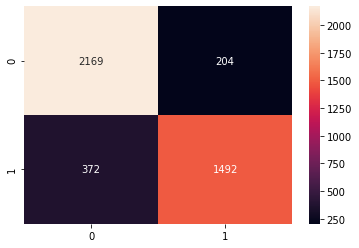

In [ ]:
# Prediction and confussion matrix
predic = model.predict_classes(x_test)
true = [np.argmax(x) for x in y_test]

cm = confusion_matrix(true, predic)
heatmap(cm, annot = True, fmt = 'd')

### Metrics

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict_classes(x_test)
y_true = np.array([np.argmax(x) for x in y_test])

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2373
           1       0.88      0.80      0.84      1864

    accuracy                           0.86      4237
   macro avg       0.87      0.86      0.86      4237
weighted avg       0.87      0.86      0.86      4237



## Test 2

In [ ]:
text = np.array(['Che @bbva_argentina no me dejan comprar dolares por una supuesta “refinanciación” de una tarjeta. Lo cual no es mi caso. Me pueden solucionar esto?',
                 '¿No les pasa que quieres usar la app de @BBVA_Mex y a fuerza quieren que des tus datos biométricos sin tu consentimiento?',
                 'Ponganse las pilas Casas de bolsa, ya BBVA',
                 'perdida de tiempo'])
dt2 = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=maxlen)

In [ ]:
model.predict_classes(dt2)

array([1, 0, 1, 1])

In [ ]:
sent_dic

{'N': 1, 'P': 0}